In [6]:
# Raw Package
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from itertools import cycle
import plotly.express as px


#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

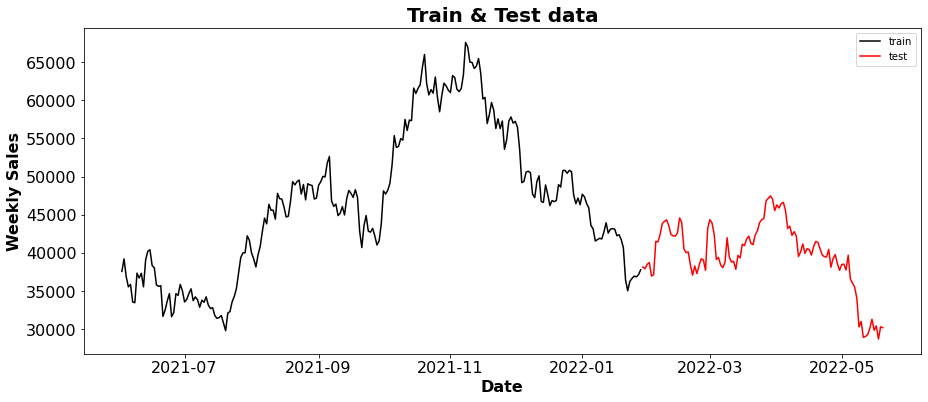

In [55]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Date'][:241], y = close_stock['Close'][:241], color = 'black')
sns.lineplot(x = close_stock['Date'][241:], y = close_stock['Close'][241:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [56]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [57]:
time_step = 21
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (225, 21)
y_train:  (225,)
X_test:  (84, 21)
y_test (84,)


In [58]:
# Biulding Model

my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [59]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.03603043033550259
Root Mean squared Error - RMSE : 0.04832415758677485


In [60]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (225, 1)
Test data prediction: (84, 1)


In [61]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [62]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','Date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (353, 1)
Test predicted data:  (353, 1)


In [63]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = my_model.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = my_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [64]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[22 23 24 25 26 27 28 29 30 31]


In [65]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [66]:
my_model=closedf.tolist()
my_model.extend((np.array(lst_output).reshape(-1,1)).tolist())
my_model=scaler.inverse_transform(my_model).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(my_model,labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [67]:
df1 = yf.download(tickers='EURUSD=X', period = '1y', interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [68]:
df1

Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-05-20  1.217285  1.222901  1.217093  1.217285   1.217285       0
2021-05-21  1.222793  1.224200  1.217374  1.222539   1.222539       0
2021-05-24  1.218116  1.222942  1.217582  1.218324   1.218324       0
2021-05-25  1.221449  1.226700  1.221240  1.221464   1.221464       0
2021-05-26  1.224890  1.226500  1.220003  1.224909   1.224909       0
...              ...       ...       ...       ...        ...     ...
2022-05-16  1.040063  1.043798  1.039134  1.040063   1.040063       0
2022-05-17  1.043896  1.055376  1.043242  1.043896   1.043896       0
2022-05-18  1.054786  1.056412  1.049241  1.054786   1.054786       0
2022-05-19  1.047274  1.059805  1.046605  1.047274   1.047274       0
2022-05-20  1.058649  1.059547  1.055966  1.057306   1.057306       0

[262 rows x 6 columns]

In [69]:
df2 = yf.download(tickers='^GSPC', period = '1y', interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [70]:
df2

Open         High          Low        Close    Adj Close  \
Date                                                                          
2021-05-20  4121.970215  4172.799805  4121.970215  4159.120117  4159.120117   
2021-05-21  4168.609863  4188.720215  4151.720215  4155.859863  4155.859863   
2021-05-24  4170.160156  4209.520020  4170.160156  4197.049805  4197.049805   
2021-05-25  4205.939941  4213.419922  4182.520020  4188.129883  4188.129883   
2021-05-26  4191.589844  4202.609863  4184.109863  4195.990234  4195.990234   
...                 ...          ...          ...          ...          ...   
2022-05-13  3963.899902  4038.879883  3963.899902  4023.889893  4023.889893   
2022-05-16  4013.020020  4046.459961  3983.989990  4008.010010  4008.010010   
2022-05-17  4052.000000  4090.719971  4033.929932  4088.850098  4088.850098   
2022-05-18  4051.979980  4051.979980  3911.909912  3923.679932  3923.679932   
2022-05-19  3899.000000  3945.959961  3876.580078  3900.790039  3900.790039   

                Volume  
Date                    
2021-05-20  3019060000  
2021-05-21  3344620000  
2021-05-24  2947400000  
2021-05-25  3420870000  
2021-05-26  3674490000  
...                ...  
2022-05-13  4142950000  
2022-05-16  3824320000  
2022-05-17  3846580000  
2022-05-18  4428960000  
2022-05-19  4212140000  

[253 rows x 6 columns]

In [71]:
df3 = yf.download(tickers='^IRX', period = '1y', interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [72]:
df3

Open   High    Low  Close  Adj Close  Volume
Date                                                     
2021-05-20  0.003  0.003  0.003  0.003      0.003       0
2021-05-21  0.003  0.003  0.003  0.003      0.003       0
2021-05-24  0.003  0.003  0.003  0.003      0.003       0
2021-05-25  0.010  0.010  0.010  0.010      0.010       0
2021-05-26  0.010  0.010  0.005  0.005      0.005       0
...           ...    ...    ...    ...        ...     ...
2022-05-13  0.913  0.963  0.913  0.943      0.943       0
2022-05-16  0.943  0.985  0.943  0.980      0.980       0
2022-05-17  1.025  1.043  1.015  1.038      1.038       0
2022-05-18  1.038  1.040  0.998  1.003      1.003       0
2022-05-19  0.000  1.000  1.000  1.000      1.000       0

[253 rows x 6 columns]